<a href="https://colab.research.google.com/github/shizuo-kaji/DemoFeatureInvariance/blob/main/colab_regression_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invariance and Representation in Machine Learning

This notebook demonstrates how **input representation** (feature engineering) critically impacts machine learning performance. You will explore this concept using a simple, interpretable geometric dataset: 2D triangles.

## Learning Objectives
1.  **Feature Representation**: Why raw data (e.g., coordinates) isn't always the best input.
2.  **Invariance**: How removing "nuisance" variations (rotation, translation) simplifies learning.
3.  **Target Dependence**: A representation good for *area* might be bad for *position*.

## The Task
Predict three targets from triangle coordinates $(x_1, y_1), (x_2, y_2), (x_3, y_3)$:
1.  **$u$ (Position)**: Centroid sum ($x_c + y_c$). Depends on absolute position.
2.  **$v$ (Area)**: Triangle area. Depends on shape & scale.
3.  **$w$ (Shape)**: Sum of squared angles. Depends only on intrinsic shape.


In [1]:
# @title 1. Setup & Dependencies
# Run this cell to install necessary packages and import libraries.

!pip install -q numpy pandas scikit-learn matplotlib seaborn

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style='whitegrid')
np.random.seed(42)
print("Setup complete.")

Setup complete.


In [2]:
# @title 2. Data Generation
# This function generates random triangles and calculates u, v, w.

def area_triangle(x1, y1, x2, y2, x3, y3):
    return 0.5 * abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))

def centroid_sum(x1, y1, x2, y2, x3, y3):
    return (x1 + x2 + x3)/3.0 + (y1 + y2 + y3)/3.0

def get_angles(x1, y1, x2, y2, x3, y3):
    a = np.hypot(x2-x3, y2-y3)
    b = np.hypot(x1-x3, y1-y3)
    c = np.hypot(x1-x2, y1-y2)
    if a==0 or b==0 or c==0: return float('nan')
    # Law of cosines
    def safe_acos(val):
        return math.acos(max(-1.0, min(1.0, val)))
    A = safe_acos((b**2 + c**2 - a**2)/(2*b*c))
    B = safe_acos((a**2 + c**2 - b**2)/(2*a*c))
    C = safe_acos((a**2 + b**2 - c**2)/(2*a*b))
    return A, B, C

def generate_dataset(n=2000):
    data = []
    for _ in range(n):
        # Generate random coordinates in [-10, 10]
        coords = np.random.uniform(-10, 10, 6)
        x1, y1, x2, y2, x3, y3 = coords

        v = area_triangle(x1, y1, x2, y2, x3, y3)
        if v < 1e-3: continue # Skip degenerate triangles

        u = centroid_sum(x1, y1, x2, y2, x3, y3)
        angles = get_angles(x1, y1, x2, y2, x3, y3)
        if isinstance(angles, float): continue
        w = sum([ang**2 for ang in angles])

        row = {'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2, 'x3':x3, 'y3':y3, 'u':u, 'v':v, 'w':w}
        data.append(row)

    return pd.DataFrame(data)

df = generate_dataset()
print(f"Generated {len(df)} samples.")
df.head()

Generated 2000 samples.


,x1,y1,x2,y2,x3,y3,u,v,w
0,-2.509198,9.014286,4.639879,1.973170,-6.879627,-6.880110,-0.213867,72.201477,3.598957
1,-8.838328,7.323523,2.022300,4.161452,-9.588310,9.398197,1.492945,10.080383,5.504407
2,6.648853,-5.753218,-6.363501,-6.331910,-3.915155,0.495129,-5.073267,43.709500,3.639083
3,-1.361100,-4.175417,2.237058,-7.210123,-4.157107,-2.672763,-5.779817,1.539137,8.631175
4,-0.878600,5.703519,-6.006524,0.284689,1.848291,-9.070992,-2.706539,45.269567,3.990815


In [3]:
# @title 3. Helper Functions: Training & Preprocessing

REGRESSORS = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'MLP (Neural Net)': MLPRegressor(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42)
}

def preprocess_data(df, mode='none'):
    # Extract raw coords
    X_raw = df[['x1','y1','x2','y2','x3','y3']].values

    if mode == 'none':
        return pd.DataFrame(X_raw, columns=['x1','y1','x2','y2','x3','y3'])

    elif mode == 'congruent':
        # Translate p1 to origin, rotate p2 to x-axis
        new_X = []
        for row in X_raw:
            x1,y1,x2,y2,x3,y3 = row
            # Translate
            tx2, ty2 = x2-x1, y2-y1
            tx3, ty3 = x3-x1, y3-y1
            # Rotate
            theta = math.atan2(ty2, tx2)
            c, s = math.cos(-theta), math.sin(-theta)
            rx2 = tx2*c - ty2*s
            ry2 = tx2*s + ty2*c # Should be 0
            rx3 = tx3*c - ty3*s
            ry3 = tx3*s + ty3*c
            # Flip if y3 < 0 to handle reflection
            if ry3 < 0: ry3 = -ry3
            new_X.append([rx2, rx3, ry3])
        return pd.DataFrame(new_X, columns=['x2_new','x3_new','y3_new'])

    elif mode == 'similar':
        # Same as congruent but scale so p2 is at (1,0)
        new_X = []
        for row in X_raw:
            x1,y1,x2,y2,x3,y3 = row
            # Translate
            tx2, ty2 = x2-x1, y2-y1
            tx3, ty3 = x3-x1, y3-y1
            # Rotate
            dist_p1p2 = math.hypot(tx2, ty2)
            theta = math.atan2(ty2, tx2)
            scale = 1.0 / dist_p1p2 if dist_p1p2 != 0 else 0
            c, s = math.cos(-theta), math.sin(-theta)
            # Apply rotation & scale to p3
            rx3 = (tx3*c - ty3*s) * scale
            ry3 = (tx3*s + ty3*c) * scale
            if ry3 < 0: ry3 = -ry3
            new_X.append([rx3, ry3])
        return pd.DataFrame(new_X, columns=['x3_sim','y3_sim'])

    elif mode == 'length':
        # Edge lengths
        new_X = []
        for row in X_raw:
            x1,y1,x2,y2,x3,y3 = row
            a = math.hypot(x2-x3, y2-y3)
            b = math.hypot(x1-x3, y1-y3)
            c = math.hypot(x1-x2, y1-y2)
            new_X.append([a,b,c])
        return pd.DataFrame(new_X, columns=['len_a','len_b','len_c'])

    elif mode == 'angle':
        # Two angles
        new_X = []
        for row in X_raw:
            x1,y1,x2,y2,x3,y3 = row
            A, B, C = get_angles(x1,y1,x2,y2,x3,y3)
            new_X.append([A, B])
        return pd.DataFrame(new_X, columns=['angle_A','angle_B'])

def run_experiment(df, mode='none'):
    X = preprocess_data(df, mode)
    y = df[['u', 'v', 'w']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results = []
    print(f"--- Results for Mode: {mode} ---")
    print(f"{'-'*60}")
    print(f"{'Target':<10} | {'Model':<15} | {'R2 Score':<10} | {'MSE':<10}")
    print(f"{'-'*60}")

    for target in ['u', 'v', 'w']:
        for name, model in REGRESSORS.items():
            pipe = make_pipeline(StandardScaler(), model)
            pipe.fit(X_train, y_train[target])
            pred = pipe.predict(X_test)
            r2 = r2_score(y_test[target], pred)
            mse = mean_squared_error(y_test[target], pred)
            results.append({'mode': mode, 'target': target, 'model': name, 'r2': r2, 'mse': mse})

            if r2 > 0.5: color = '\033[92m' # Green for good
            elif r2 > 0: color = '\033[93m' # Yellow for okay
            else: color = '\033[91m'       # Red for bad

            print(f"{target:<10} | {name:<15} | {color}{r2:.4f}\033[0m     | {mse:.4f}")
        print(f"{'-'*60}")
    return pd.DataFrame(results)

## Experiment 1: Raw Coordinates (`none`)
**Hypothesis:**
- $u$ (Position): Should be easy (Linear). $u$ is literally a linear combination of inputs.
- $v$ (Area): Should be harder. Area is non-linear (multiplicative).
- $w$ (Angles): Should be hard. Angles involve trigonometry (highly non-linear).

In [5]:
res_none = run_experiment(df, mode='none')

--- Results for Mode: none ---
------------------------------------------------------------
Target     | Model           | R2 Score   | MSE       
------------------------------------------------------------
u          | Linear          | 1.0000     | 0.0000
u          | Ridge           | 1.0000     | 0.0000
u          | MLP (Neural Net) | 0.9995     | 0.0108
u          | RandomForest    | 0.9283     | 1.5465
------------------------------------------------------------
v          | Linear          | -0.0160     | 635.4924
v          | Ridge           | -0.0159     | 635.4856
v          | MLP (Neural Net) | 0.9372     | 39.2533
v          | RandomForest    | 0.4562     | 340.1380
------------------------------------------------------------
w          | Linear          | -0.0047     | 2.9455
w          | Ridge           | -0.0047     | 2.9455
w          | MLP (Neural Net) | 0.6280     | 1.0906
w          | RandomForest    | 0.0662     | 2.7377
--------------------------------------------

## Experiment 2: Invariance (`congruent`)
We translate the triangle so $p_1$ is at $(0,0)$ and rotate it so $p_2$ is on the x-axis.

**Hypothesis:**
- **Position information is destroyed.** $u$ prediction should fail.
- **Area and Shape information is preserved.** $v$ and $w$ should improve because the model doesn't have to learn rotation invariance.

In [4]:
res_congruent = run_experiment(df, mode='congruent')

--- Results for Mode: congruent ---
------------------------------------------------------------
Target     | Model           | R2 Score   | MSE       
------------------------------------------------------------
u          | Linear          | -0.0016     | 21.6053
u          | Ridge           | -0.0016     | 21.6052
u          | MLP (Neural Net) | -0.0938     | 23.5940
u          | RandomForest    | -0.1185     | 24.1261
------------------------------------------------------------
v          | Linear          | 0.8060     | 121.3644
v          | Ridge           | 0.8060     | 121.3194
v          | MLP (Neural Net) | 0.9998     | 0.1510
v          | RandomForest    | 0.9921     | 4.9183
------------------------------------------------------------
w          | Linear          | 0.3929     | 1.7797
w          | Ridge           | 0.3929     | 1.7797
w          | MLP (Neural Net) | 0.9819     | 0.0532
w          | RandomForest    | 0.9373     | 0.1839
--------------------------------------

## Experiment 3: Scale Invariance (`similar`)
We translate, rotate, AND scale the triangle so the base length is 1.

**Hypothesis:**
- **Scale information is destroyed.** Area $v$ depends on scale, so prediction should fail.
- **Shape information is preserved.** Angles $w$ only depend on shape, so they should still be predictable.

In [6]:
res_similar = run_experiment(df, mode='similar')

--- Results for Mode: similar ---
------------------------------------------------------------
Target     | Model           | R2 Score   | MSE       
------------------------------------------------------------
u          | Linear          | -0.0017     | 21.6058
u          | Ridge           | -0.0017     | 21.6058
u          | MLP (Neural Net) | -0.0334     | 22.2903
u          | RandomForest    | -0.1641     | 25.1086
------------------------------------------------------------
v          | Linear          | -0.0129     | 633.5504
v          | Ridge           | -0.0129     | 633.5476
v          | MLP (Neural Net) | 0.4245     | 359.9560
v          | RandomForest    | 0.3562     | 402.7213
------------------------------------------------------------
w          | Linear          | -0.0010     | 2.9347
w          | Ridge           | -0.0010     | 2.9346
w          | MLP (Neural Net) | 0.9032     | 0.2839
w          | RandomForest    | 0.9719     | 0.0824
--------------------------------

## Experiment 4: Explicit Features (`length`)
We replace coordinates with the three edge lengths $(a, b, c)$.

**Hypothesis:**
- Similar to `congruent`, but explicitly provides the geometry the area formula needs (Heron's formula).
- $v$ (Area) prediction should be very strong.

In [7]:
res_length = run_experiment(df, mode='length')

--- Results for Mode: length ---
------------------------------------------------------------
Target     | Model           | R2 Score   | MSE       
------------------------------------------------------------
u          | Linear          | -0.0032     | 21.6383
u          | Ridge           | -0.0032     | 21.6383
u          | MLP (Neural Net) | -0.1102     | 23.9474
u          | RandomForest    | -0.2435     | 26.8216
------------------------------------------------------------
v          | Linear          | 0.5592     | 275.7132
v          | Ridge           | 0.5593     | 275.6871
v          | MLP (Neural Net) | 0.9940     | 3.7228
v          | RandomForest    | 0.9248     | 47.0575
------------------------------------------------------------
w          | Linear          | 0.0217     | 2.8680
w          | Ridge           | 0.0217     | 2.8680
w          | MLP (Neural Net) | 0.9491     | 0.1492
w          | RandomForest    | 0.5665     | 1.2708
----------------------------------------

## Summary & Analysis


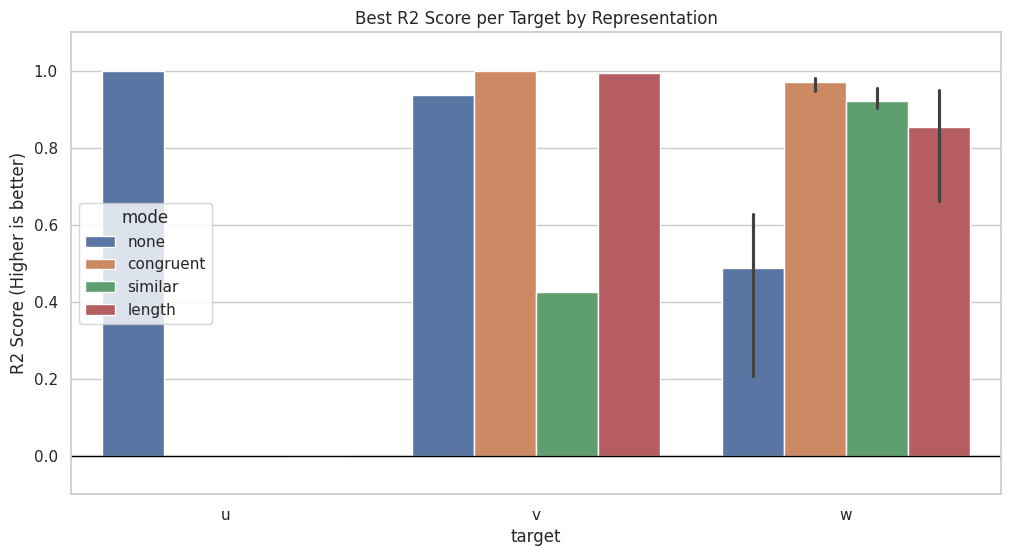

In [8]:
all_results = pd.concat([res_none, res_congruent, res_similar, res_length])

# Filter for best model per mode/target (max R2)
best_results = all_results.loc[all_results.groupby(['mode', 'target'])['r2'].idxmax()]

plt.figure(figsize=(12, 6))
sns.barplot(data=best_results, x='target', y='r2', hue='mode')
plt.title("Best R2 Score per Target by Representation")
plt.ylim(-0.1, 1.1)
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("R2 Score (Higher is better)")
plt.show()